<center><h1> A basic classification tutorial using deeplearning </h1></center>
<center><h4> SY19 - Machine Learning - 2019 </h4></center> 
<center> Yonatan-Carlos Carranza-Alarcon (ycarranz@hds.utc.fr)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<center>

This mini-tutorial relies on some notes and pieces of code from  Deep Learning with R's book **[[1,ch. 5]](https://www.manning.com/books/deep-learning-with-r)**.

# 1. Installation

First of all, it is necessary to install the following python packages:
- pip2.7 install tensorflow 
- pip2.7 install keras 
- pip2.7 install Pillow

and the following R packages:

- install.packages("reticulate")
- install.packages("tensorflow")
- tensorflow::install_tensorflow()
- install.packages("keras")

Now, we can load these packages in R and configure Keras package with **python2.7**, as follows:

In [2]:
library(dplyr)
library(reticulate)
reticulate::use_python("/usr/local/Cellar/python@2/2.7.15/bin/python2.7", required =TRUE)
reticulate::py_config()
library(tensorflow)
library(keras)
library(jpeg)
# seed to replicate the same results in others computers
tensorflow::tf$random$set_seed(1729)

python:         /usr/local/Cellar/python@2/2.7.15/bin/python2.7
libpython:      /usr/local/opt/python@2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/config/libpython2.7.dylib
pythonhome:     /usr/local/Cellar/python@2/2.7.15/Frameworks/Python.framework/Versions/2.7:/usr/local/Cellar/python@2/2.7.15/Frameworks/Python.framework/Versions/2.7
version:        2.7.15 (default, May  1 2018, 16:44:08)  [GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.1)]
numpy:          /usr/local/lib/python2.7/site-packages/numpy
numpy_version:  1.16.5

NOTE: Python version was forced by use_python function

# 2. Data set of images 

In this mini-tutorial, we use a collection of images with 2 differents classes (dogs or cats) which can be downloaded 
of Kaggle's competition named [Dogs & Cats Images](https://www.kaggle.com/chetankv/dogs-cats-images).

## 2.1. Default parameters

Parameters by default used in the whole tutorial:

1. A uniform default size for all images.  
2. Paths of training and testing data sets (images).
3. The number of images per class used to train our model. 

As regards to image size, we use a uniform(equal) size of **(180, 180)** pixels for each image.

As regards to paths, we declare two variables **train_path_images** and **test_path_images** where save the absolut paths of the training and testing instances (images) downloaded of Kaggle, respectively (do not forget that **getwd** recovery the absolute path of my workspace)

When we perform a deep learning model for first time, it is necessary to firstly check if our model (with its different convolution layers) works, because if we fit our model with all data (i.e. **12 500 images**) and a large pixel size (i.e. **(180, 180)**) it could take several hours. To do that, we only use a small part of the images downloads, i.e. **nb.sample=1000** for training and validation our model (do not forget that there is also a test folder of images for testing our final model) and a size of **(80, 80)** pixels. 

<span style="color:red;font-weight:bold"> Hint: </span> 
<span style="color:blue;"> It should be noted that the size of pixels has a strong influence on number of hours that could take our model to learn (several hours). Because, at larger pixels (e.g **(400, 400)**), it is necessary too much parameters to estimate. Another consequence of the size of pixels is the size file of our model, for example: (180, 180) pixels takes ~45mb approximately.</span>

Do not forget that after the validation, the last model our could use a size of  **(180, 180)** pixels and learn with 5500 images for train and test.

In [3]:
nb.sample <- 5500
target_size_pixel <- c(180,180)
root_path <- getwd()
# directories 'dogs-vs-cats/train' and 'dogs-vs-cats/test' of images downloaded of kaggle 
train_path_images <- file.path(root_path, 'dogs-vs-cats', 'train')
test_path_images <- file.path(root_path, 'dogs-vs-cats', 'test')

# 2.2. Visualization of images

Before building the deep-learning model, we show how potting a image, which it is sometimes necessary.

An important way to verify if the classification was correctly performed is to plot the image to predict, so here we show three different ways to do it.

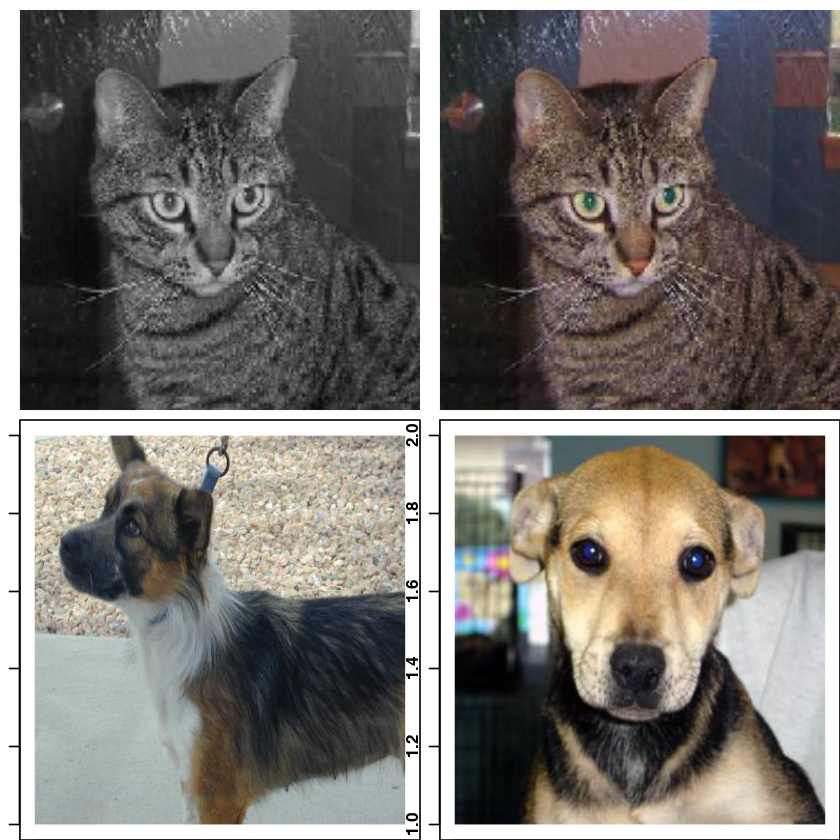

In [4]:
path <- file.path(train_path_images, 'cat.1.jpg')

par(mfrow = c(2,2), mar = c(0,1,0,0))
image_load(path, grayscale = TRUE, target_size = target_size_pixel) %>% 
    image_to_array() %>%
    array_reshape(dim = c(dim(.)[1:2])) %>%
    as.raster(max = 255L) %>%
    plot()

image_load(path, grayscale = FALSE, target_size = target_size_pixel) %>% 
    image_to_array() %>%
    `/`(., 255) %>%
    as.raster() %>%
    plot()

show_image <- function(inpath, name){
    path <- file.path(inpath, name)
    jpeg_image <- readJPEG(path, native = TRUE)
    plot(1:2, type='n')
    rasterImage(jpeg_image, 1, 1, 2, 2)
}

show_image(train_path_images, name="dog.3.jpg")
show_image(train_path_images, name="dog.4.jpg")

# 3. Prepare data

We prepare **1000** random images (i.e. **nb_sample**) each one for the training and validation of our model, beside it should also be noted that we at present work with images and we could want to re-scale the pixel values, create new images from of target image (c.f. [augmentation images](https://www.pyimagesearch.com/wp-content/uploads/2019/07/keras_data_augmentation_header.png)), and so on.

As regards to the first issues, we create two new folders: **train_keras** and **validation_keras** for saving images. It can be manually performed in your workspace by creating folders respectively, but here, we automatically perform it using the below piece code. 

We will use in the next section a simpler function **flow_images_from_directory** of Keras to rescale images (i.e. to fall between 0 and 1, $[0,1]$). This function besides generate some batch (selection an amount of images by block) that will be sent throught the neuronal network during the training, and for that <span style="color:red;font-weight:bold;">it is necesary to respect some particular structure like below, in others work, we need create subdirectories per class and put inside our images</span> (for more details an [example of tree directory](https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d))

<pre>
data/  
    train/  
        dogs/  
            dog001.jpg  
            dog002.jpg  
            ...
        cats/  
            cat001.jpg  
            cat002.jpg  
            ...  
    validation/  
        dogs/  
            dog001.jpg  
            dog002.jpg  
            ...  
        cats/  
            cat001.jpg  
            cat002.jpg  
            ...  
</pre>

Voici, the code to randomly select images to train and to validate our model.

In [5]:
# first remove folders which will be created in this code
unlink(file.path(root_path, "train_keras"), recursive = TRUE)
unlink(file.path(root_path, "validation_keras"), recursive = TRUE)

# number total of images 
nb.total.train.images <- 12500
nb.total.test.images <- 12500

# number of images used to train our deeplearning model 
idx_samples <- 1:nb.total.train.images
idx_train_samples <- sample(idx_samples, nb.sample)
idx_validation_samples <- sample(idx_samples[-idx_train_samples], nb.sample)

# creation of train directory with sub-directories by class 
root_train_path <- file.path(root_path, "train_keras")
dir.create(file.path(root_train_path, "cats"), recursive=TRUE)
dir.create(file.path(root_train_path, "dogs"), recursive=TRUE)

# creation of validation directory with sub-directories by class 
root_validation_path <- file.path(root_path, "validation_keras")
dir.create(file.path(root_validation_path, "cats"), recursive=TRUE)
dir.create(file.path(root_validation_path, "dogs"), recursive=TRUE)

# copy a sample of cats and dots instances to training directories
names_images_cats <- paste0("cat.", (idx_train_samples-1), ".jpg")
.status <- file.copy(file.path(train_path_images, names_images_cats),
                     file.path(root_train_path, "cats"))
names_images_dogs <- paste0("dog.", (idx_train_samples-1), ".jpg")
.status <- file.copy(file.path(train_path_images, names_images_dogs),
                     file.path(root_train_path, "dogs"))

# copy a sample of cats and dots instances to validation directories
names_images_cats <- paste0("cat.", (idx_validation_samples-1), ".jpg")
.status <- file.copy(file.path(train_path_images, names_images_cats),
                     file.path(root_validation_path, "cats"))
names_images_cats <- paste0("dog.", (idx_validation_samples-1), ".jpg")
.status <- file.copy(file.path(train_path_images, names_images_cats),
                     file.path(root_validation_path, "dogs"))

It should be noted that number instances for each class is balanced, in other words, these have the same amount of cat and dog images 

# 4. Define deeplearning model

This model is more complex than the simplest recognition number image of 24x24 pixels which is usually used to teach in the classroom. Since we will deal with bigger images and a more complex problem, we will build a neuronal network with more layers than usual, in order to reduce the size of feature of (180,180) pixels (aim of learning bigger and smaller pixel patterns in the network) to a smaller one, so that when it reaches the flatten layer (i.e. **layer_flatten**) which it is charged of transforming the last convolution layer of $\mathbb{R}^3$ to a vector of one dimension $\mathbb{R}$.

The **layer_conv_2d** (a.k.a. a convolution layer) is a function which learns global patterns in their input feature space (i.e. different size pixels propagated in the network) and the **layer_dense** (a.k.a. a densely connected layer) is a function which learns local patterns, for more conceptual details in [[1]](https://www.manning.com/books/deep-learning-with-r).


In [6]:
model <- keras_model_sequential() %>%
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu",
                input_shape = c(target_size_pixel, 3)) %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_dropout(0.25) %>%

  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  layer_dropout(0.25) %>%

  layer_flatten() %>%
  layer_dense(units = 512, activation = "relu") %>%
  layer_dropout(0.5) %>%
  layer_dense(units = 1, activation = "sigmoid")

The next command to show all information of layers of our model.

In [7]:
summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 178, 178, 32)            896         
________________________________________________________________________________
max_pooling2d (MaxPooling2D)        (None, 89, 89, 32)              0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 87, 87, 64)              18496       
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 43, 43, 64)              0           
________________________________________________________________________________
dropout (Dropout)                   (None, 43, 43, 64)              0           
________________________________________________________________________________
conv2d_2

We compile our model with different parameter, namely: 
* (1) a loss function for binary classification, 
* (2) a optimizator algorithm (e.g. gradient descent) and 
* (3) a metric to evaluate the performance of model.

In [8]:
model %>% compile(
  loss = "binary_crossentropy",
  optimizer = optimizer_rmsprop(lr = 1e-4),
  metrics = "accuracy"
)

# 4. Train model 

We use the **flow_images_from_directory** function to rescale images and create size of each batch. 

In [9]:
# name of each class index.
train_datagen <- image_data_generator(rescale = 1/255)
train_generator <- flow_images_from_directory(
                        directory = root_train_path, 
                        generator = train_datagen, 
                        target_size = target_size_pixel,
                        batch_size = 100,
                        class_mode = "binary")

validation_datagen <- image_data_generator(rescale = 1/255)
validation_generator <- flow_images_from_directory(
                            directory = root_validation_path, 
                            generator = validation_datagen, 
                            target_size = target_size_pixel,
                            batch_size = 100,
                            class_mode = "binary")

In [10]:
batch <- generator_next(train_generator)
str(batch)

List of 2
 $ : num [1:100, 1:180, 1:180, 1:3] 0.227 0.337 0.714 0.192 0.769 ...
 $ : num [1:100(1d)] 1 1 1 1 0 1 0 0 0 0 ...


Fitting the deep-learning model with 30 epochs and indicate the validation and training data sets.

In [11]:
history <- model %>% fit_generator(train_generator,
                                   steps_per_epoch = 100, 
                                   epochs = 30, 
                                   validation_data = validation_generator,
                                   validation_steps = 50,
                                   workers = 1)

Saving the deep-learning model which could be used to evaluate reliability of our classification model in the next section.

In [13]:
model %>% save_model_hdf5("cat_and_dog_model.h5")

Showing the accuracy and loss performance obtained from training and validation data sets.

Warning message in as.POSIXlt.POSIXct(Sys.time()):
“unknown timezone 'zone/tz/2019c.1.0/zoneinfo/Europe/Paris'”


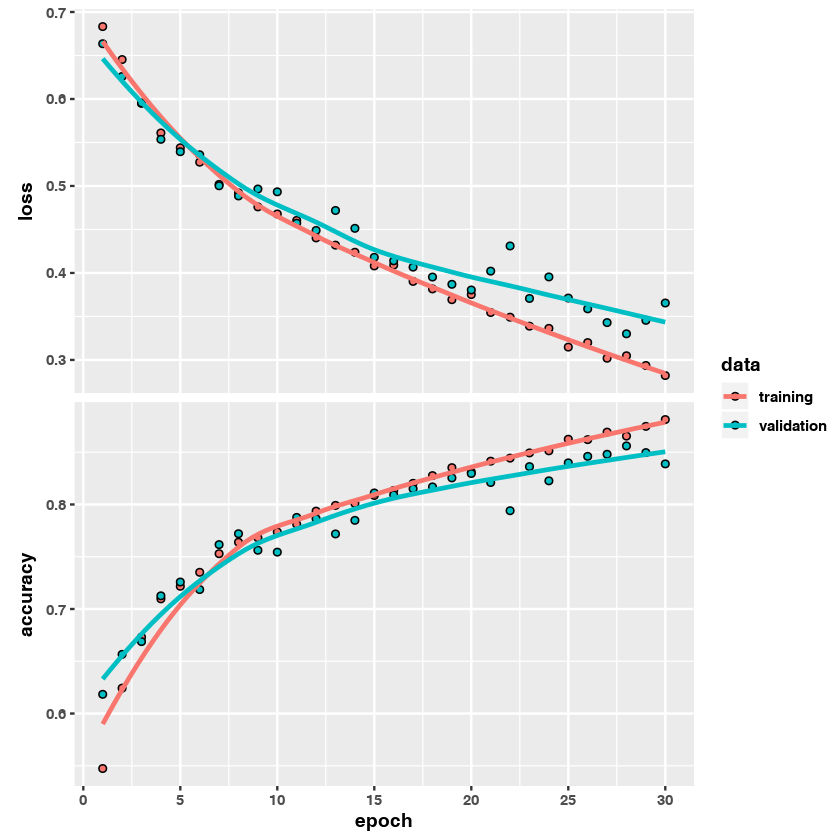

In [12]:
plot(history)

# 5. Test model 

Same as in teh section 3 and 4, we create a test directory with the images that were not used in training and validation model.

In [42]:
# first remove test folder
unlink(file.path(root_path, "test_keras"), recursive = TRUE)
# index of testing sample images
idx_test_samples <- idx_samples[-c(idx_train_samples, idx_validation_samples)]

# creation of test directory with sub-directories by class 
root_test_path <- file.path(root_path, "test_keras")
dir.create(file.path(root_test_path, "cats"), recursive=TRUE)
dir.create(file.path(root_test_path, "dogs"), recursive=TRUE)

# copy a sample of cats and dots instances to testing directories
names_images_cats <- paste0("cat.", (idx_test_samples-1), ".jpg")
.status <- file.copy(file.path(train_path_images, names_images_cats),
                     file.path(root_test_path, "cats"))
names_images_dogs <- paste0("dog.", (idx_test_samples-1), ".jpg")
.status <- file.copy(file.path(train_path_images, names_images_dogs),
                     file.path(root_test_path, "dogs"))

# rescaling the testing data set 
testing_datagen <- image_data_generator(rescale = 1/255)
testing_generator <- flow_images_from_directory(
                        directory = root_test_path, 
                        generator = validation_datagen, 
                        target_size = target_size_pixel,
                        batch_size = 20,
                        class_mode = "binary")

# 6. Accuracy

In order to calculate the performance (or reliability of the classifier), we use the **evaluate_generator** function with test directory created in the last section.

In [46]:
model %>% evaluate_generator(testing_generator, steps = 50)

$loss
[1] 0.3635464

$accuracy
[1] 0.834

It is good !, the accuracy is very high $<80\%$, it sounds good to get a reliable prediction for new images. 

# 7. Forecasting

Firstly, we recovery the model created previously.

In [44]:
model <- load_model_hdf5("cat_and_dog_model.h5")

we also recovery index classes generated from **train_generator** variable.

In [45]:
class_names <- train_generator$class_indices
class_names

$cats
[1] 0

$dogs
[1] 1

Now, we load a random image from the directory test download and plot in order to know if it is a dog or cat class.

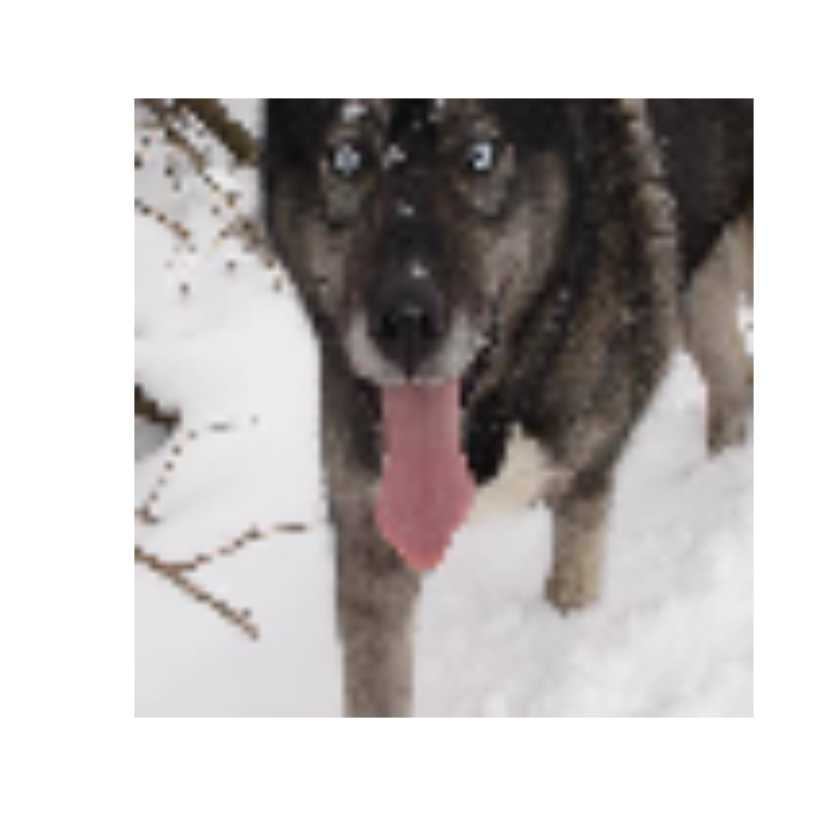

In [101]:
name_image <- paste0(sample(1:nb.total.test.images, 1), '.jpg')
image_path <- file.path(test_path_images, name_image)
test_image <- image_load(image_path, target_size = target_size_pixel)
image_tensor <- image_to_array(test_image)
image_tensor <- array_reshape(image_tensor, c(1, target_size_pixel, 3))
image_tensor <- image_tensor / 255
plot(as.raster(image_tensor[1,,,]))

Then, we calculate the predictive probability and class:

In [102]:
paste0("Probability: ", round(predict_proba(model, x=image_tensor), 2))
paste0("Predicted class: ", predict_classes(model, x=image_tensor))

[1] "Probability: 0.77"

[1] "Predicted class: 1"

So, with a predictive probability **0.77** we can predict that image belongs to class **dog**, Cool !! 

# References


[1] Francois Chollet and J. J. Allaire. 2018. Deep Learning with R (1st ed.). Manning Publications Co., Greenwich, CT, USA.